In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from utils.denoise import *
from utils.data_io import *
from utils.plot import get_plt
from utils.property import ICESAT2Properties

plt.rcParams["font.family"] = ["Times New Roman","SimHei"]

Index(['Unnamed: 0', 'Time (sec)', 'Delta Time (sec)', 'Segment ID', 'GT Num',
       'Beam Num', 'Beam Type', 'Latitude (deg)', 'Longitude (deg)',
       'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone', 'UTM Hemisphere',
       'Cross-Track (m)', 'Along-Track (m)', 'Height (m HAE)',
       'Height (m MSL)', 'Classification', 'Signal Confidence',
       'Solar Elevation (deg)'],
      dtype='object')
object


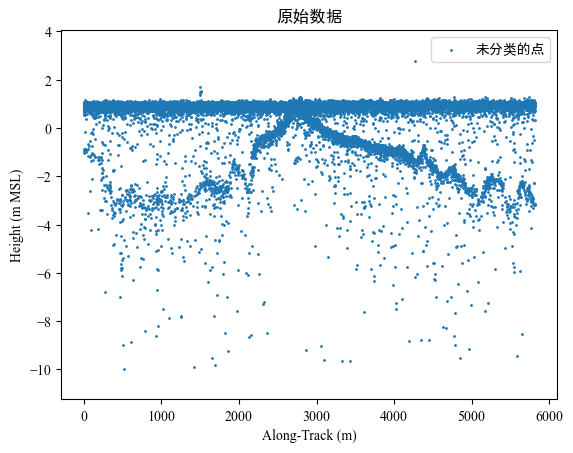

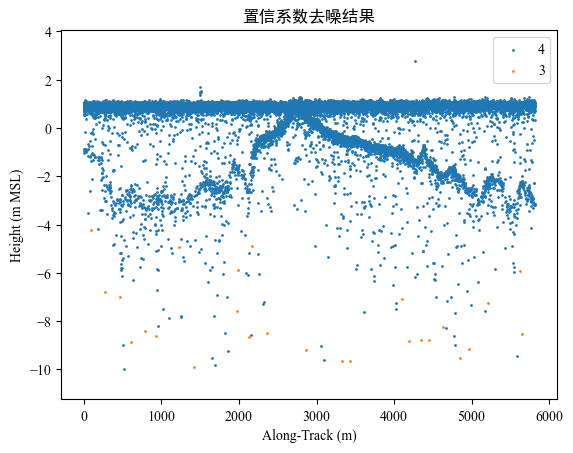

C:\Users\natsuu\AppData\Local\Temp\ipykernel_26300\3721855802.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Overwrite operation cancelled by user.


False

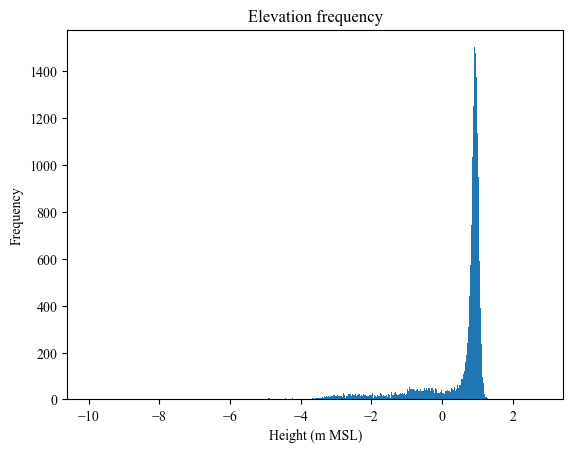

In [3]:
path_str = "processed_ATL03_20221230185202_01561807_006_02_gt3r_cut.csv"
data_path = Path(path_str)

df = None
with open(data_path, 'r') as f:
    df = pd.read_csv(f)
    
print(df.columns)

df["point_type"] = PointType.NotClassified.value
print(df["point_type"].dtypes)
get_plt(df,"原始数据")
get_plt(df,"置信系数去噪结果", type_lable=ICESAT2Properties.SignalConfidence.value)

# 高程频率图

plt.clf()
plt.hist(df["Height (m MSL)"], bins="auto")
plt.xlabel("Height (m MSL)")
plt.ylabel("Frequency")
# plt.title("高程频率图")
plt.title("Elevation frequency")
fig = plt.gcf()
fig.show()

save_csv(df, "intermediate_data", tag="origin", overwrite=True)

In [ ]:
sea_level, water_surface = get_sea_level(df, n_sigmas=0.8)

print(f"sea_level: {sea_level}, limit: {water_surface}")

df.loc[
    (df["Height (m MSL)"] > water_surface[0])
    & (df["Height (m MSL)"] < water_surface[1]),
    "point_type",
] = PointType.WaterSurface.value

df.loc[(df["Height (m MSL)"] >= water_surface[1]), "point_type"] = PointType.Noise.value
df.loc[(df["Height (m MSL)"] < water_surface[1]), "point_type"] = PointType.WaterSurface.value
df.loc[(df["Height (m MSL)"] < water_surface[0]), "point_type"] = PointType.UnderWater.value

sea_level: 0.8073118184511227, limit: (np.float64(0.5446190736047178), np.float64(1.0700045632975275))
Save intermediate_data_water_surface.csv successfully!
filename: intermediate_data_water_surface.csv


True

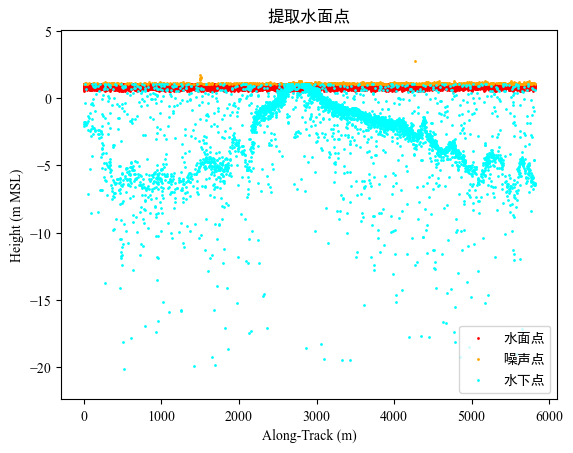

Save intermediate_data_water_surface.csv successfully!
filename: intermediate_data_water_surface.csv


True

In [8]:
# 筛选出高度低于水面的数据
underwater_mask = df["Height (m MSL)"] < water_surface[0]

# 获取需要调整高度的数据列
under_water_point = df.loc[underwater_mask, "Height (m MSL)"]

# 调整高度
real_depth = under_water_point.apply(get_real_depth, args=(sea_level,))

# 将调整后的高度赋值回原数据框
df.loc[underwater_mask, "Height (m MSL)"] = sea_level - real_depth

get_plt(df=df,title="提取水面点")
save_csv(df, "intermediate_data", tag="water_surface", overwrite=True)

样本数量：4137
类型数量：1
噪声点数量：1457
噪声点比例：0.35218757553782937
样本数量：4137
有效点数量：2680
噪声点数量：1457
有效点比例：0.6478124244621707
噪声点比例：0.35218757553782937


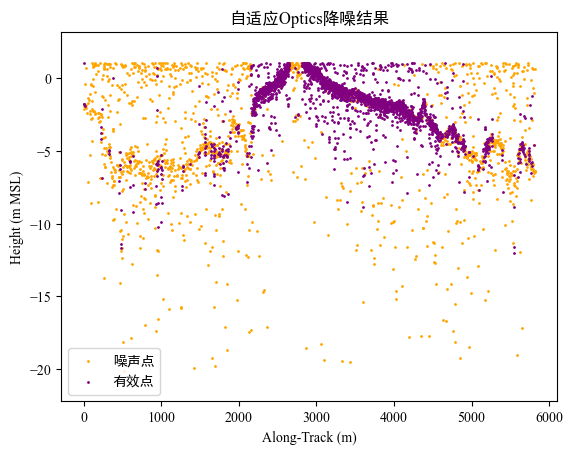

Save intermediate_data_optics.csv successfully!
filename: intermediate_data_optics.csv


True

In [9]:
# optics_clustering_denoise的效果更好
under_water_point = df.loc[underwater_mask].copy()
noise_points = optics_clustering_denoise(under_water_points=under_water_point)
original_indices = under_water_point.index[noise_points]
df.loc[original_indices, "point_type"] = PointType.Noise.value

land_points = np.logical_not(noise_points)
original_indices = under_water_point.index[land_points]
df.loc[original_indices, "point_type"] = PointType.Valid.value

# get_plt(df,"All Data")
get_plt(df.loc[underwater_mask],"自适应Optics降噪结果")
save_csv(df, "intermediate_data", tag="optics", overwrite=True)


# under_water_point = df.loc[underwater_mask].copy()
# noise_points = dbscan_denoise(under_water_points=under_water_point, eps=8, min_samples=10)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = adaptive_elliptical_denoise(under_water_points=under_water_point,k=3,alpha=0.1)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = adaptive_optics_denoise(under_water_point, eps=1)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)
# get_plt(df.loc[underwater_mask])

区块 0.0 可能是陆地
区块 52.0 可能是陆地
区块 55.0 可能是陆地
区块 56.0 可能是陆地
区块 57.0 可能是陆地


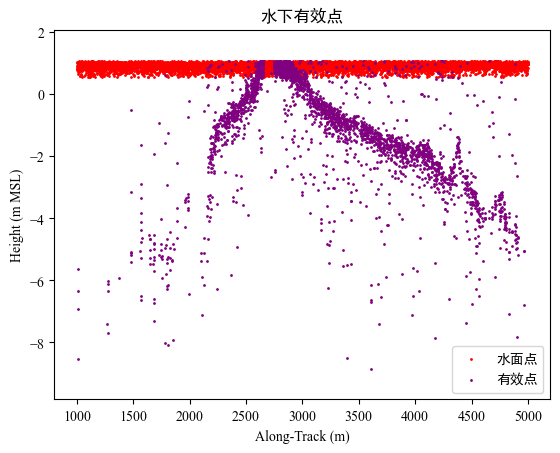

Save intermediate_data_effective_point.csv successfully!
filename: intermediate_data_effective_point.csv


True

In [10]:
df = df.loc[df["point_type"] != PointType.Noise.value]

df["block"] = df[ICESAT2Properties.AlongTrack.value] // 50
unique_blocks = df["block"].unique()
for i in unique_blocks:
    above_water_points_num = df[(df["block"] == i) & (df["Height (m MSL)"] >= water_surface[0])].shape[0]
    under_water_points_num = df[(df["block"] == i) & (df["Height (m MSL)"] < water_surface[0])].shape[0]
    min_under_water_point = df[df["block"] == i]["Height (m MSL)"].min()
    if  1 < under_water_points_num and under_water_points_num < 25 and min_under_water_point > -3:
        print(f"区块 {i} 可能是陆地")
        df.loc[(df["block"] == i) & (df["Height (m MSL)"] >= water_surface[0]), "point_type"] = PointType.Valid.value

df = df.loc[(df[ICESAT2Properties.AlongTrack.value] > 1000)&(df[ICESAT2Properties.AlongTrack.value] < 5000)]

get_plt(df, title="水下有效点")
save_csv(df, "intermediate_data", tag="effective_point", overwrite=True)

In [14]:
save_csv(df, data_path.stem, tag="denoise", backup=True, overwrite=True)

Overwrite operation cancelled by user.


False